In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, activations, Input
import time
import dxchange
from IPython import display

In [2]:
def nor_data(img):
    mean_tmp = np.mean(img)
    std_tmp = np.std(img)
    img = (img - mean_tmp) / std_tmp
    img = (img - img.min()) / (img.max() - img.min())
    return img

def angles(nang, ang1=0., ang2=180.):
    return np.linspace(ang1 * np.pi / 180., ang2 * np.pi / 180., nang)
fname_data = '/data/ganrec/prj_shale.tiff'
data = dxchange.read_tiff(fname_data)
nang, nslice, px = data.shape
    # ang = np.arange(nang)
theta = angles(nang, ang1=0, ang2=180)
slice = 100
prj = data[:,slice,:]
prj = nor_data(prj)

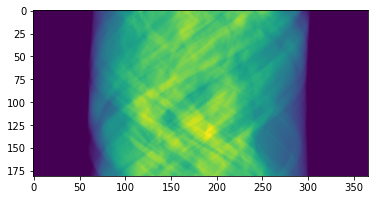

In [3]:
plt.imshow(prj)
plt.show()

In [13]:
print(data.shape)

(181, 160, 366)


In [39]:
def dense_norm(units, dropout = 0.25, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = tf.keras.Sequential()
    result.add(
        layers.Dense(units, activation=tf.nn.tanh, use_bias=True, kernel_initializer=initializer))
    result.add(layers.Dropout(dropout))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

#     result.add(layers.LeakyReLU())

    return result


def conv2d_norm(filters, size, strides, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=strides, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result


def dconv2d_norm(filters, size, strides, apply_dropout=False):
    initializer = tf.random_normal_initializer()

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=strides,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def make_generator(inputs, conv_num, conv_size, dropout, px):
  
    img_size = px
    fc_size = img_size ** 2

    # inputs = tf.keras.layers.Input(shape=[img_size, img_size, 1])
    initializer = tf.random_normal_initializer(0., 0.02)
    x = tf.keras.layers.Flatten()(inputs)
    x = dense_norm(conv_num * 4)(x)
    x = dense_norm(conv_num * 4)(x)
    x = dense_norm(conv_num * 4)(x)
    x = dense_norm(fc_size)(x)
    x = tf.reshape(x, shape=[-1, img_size, img_size, 1])
    x = conv2d_norm(conv_num, conv_size, 1)(x)
    x = conv2d_norm(conv_num, conv_size, 1)(x)
    x = conv2d_norm(conv_num * 2, conv_size, 1)(x)
    x = conv2d_norm(conv_num * 2, conv_size, 1)(x)
    x = conv2d_norm(1, conv_size, 1)(x)
       
    
    return tf.keras.Model(inputs=inputs, outputs=x)



# def make_generator(inputs, conv_num, conv_size, dropout, px):
  
#     img_size = px
#     fc_size = img_size ** 2

#     # inputs = tf.keras.layers.Input(shape=[img_size, img_size, 1])
#     x = tf.keras.layers.Flatten()(inputs)
# #     print(inputs.shape)
#     fc_stack = [
#         dense_norm(conv_num * 4),
#         dense_norm(conv_num * 4),
#         dense_norm(conv_num * 4),
#         dense_norm(fc_size),
#     ]

#     conv_stack = [
#         conv2d_norm(conv_num, conv_size, 1),
#         conv2d_norm(conv_num, conv_size, 1),
#         conv2d_norm(conv_num * 2, conv_size, 1),
#         conv2d_norm(conv_num * 2, conv_size, 1),
#         conv2d_norm(conv_num, conv_size, 1),
#         conv2d_norm(conv_num, conv_size, 1),
#     ]

#     initializer = tf.random_normal_initializer(0., 0.02)
#     last = tf.keras.layers.Conv2DTranspose(1, 4,
#                                            strides=1,
#                                            padding='same',
#                                            kernel_initializer=initializer,
#                                            activation='relu')  # (batch_size, 256, 256, 3)

#     # Fully connected layers through the model

#     for fc in fc_stack:
#         x = fc(x)

#     x = tf.reshape(x, shape=[-1, img_size, img_size, 1])
#     # Convolutions
#     for conv in conv_stack:
#         x = conv(x)
#     x = last(x)

#     return tf.keras.Model(inputs=inputs, outputs=x)


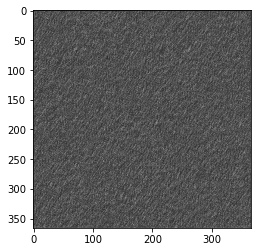

In [40]:
inputs = Input(shape=(nang, px, 1))
generator = make_generator(inputs, 32, 3, 0.5, 366)
prj = prj.reshape((1, 181, 366, 1))
generated_image = generator(prj)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [41]:
tf.print(generated_image)

[[[[-0.000756307738]
   [-0.000203507123]
   [-0.000569434895]
   ...
   [-0.000477961556]
   [0.0022383146]
   [0.00314039481]]

  [[0.000686933286]
   [-0.000896962069]
   [0.00168349931]
   ...
   [0.00439860579]
   [0.000333399657]
   [0.00120183581]]

  [[0.00424593594]
   [0.00282292883]
   [0.00109353056]
   ...
   [0.00530156121]
   [0.00360044767]
   [0.00200706697]]

  ...

  [[0.00201146328]
   [-0.00112506258]
   [0.0070286165]
   ...
   [0.00522710104]
   [0.00555685349]
   [-0.00128557638]]

  [[0.00633966597]
   [0.00172193442]
   [0.00568729872]
   ...
   [0.00446682842]
   [0.000377661112]
   [0.00485966261]]

  [[0.00265276409]
   [0.00206780061]
   [0.00306507456]
   ...
   [0.00213378505]
   [0.00191721669]
   [-0.000155378366]]]]


In [5]:
def make_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[px, px, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[px, px, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = conv2d_norm(64, 4, 2)(x)  # (batch_size, 128, 128, 64)
    down2 = conv2d_norm(128, 4, 2)(down1)  # (batch_size, 64, 64, 128)
    down3 = conv2d_norm(256, 4, 2)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [5]:
def make_discriminator_model(nang, px):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[nang, px, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [6]:
discriminator = make_discriminator_model(181, 366)
decision = discriminator(prj)
# print (decision)

In [7]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                                       labels=tf.ones_like(real_output)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                       labels=tf.zeros_like(fake_output)))
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def generator_loss(fake_output, img_output, pred):
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                      labels=tf.ones_like(fake_output))) \
               + tf.reduce_mean(tf.abs(img_output - pred)) * 10
    return gen_loss

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
checkpoint_dir = '/data/ganrec/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
def tfnor_data(img):
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img


def tomo_bp(sinoi, ang):
    prj = tfnor_data(sinoi)
    d_tmp = sinoi.shape
    # print d_tmp
    prj = tf.reshape(prj, [1, d_tmp[1], d_tmp[2], 1])
    prj = tf.tile(prj, [d_tmp[2], 1, 1, 1])
    prj = tf.transpose(prj, [1, 0, 2, 3])
    prj = tfa.image.rotate(prj, ang)
    bp = tf.reduce_mean(prj, 0)
    bp = tf.image.per_image_standardization(bp)
    bp = tf.reshape(bp, [1, bp.shape[0], bp.shape[1], bp.shape[2]])
    return bp


# @tf.function
def tomo_radon(rec, ang):
    nang = ang.shape[0]
    img = tf.transpose(rec, [3, 1, 2, 0])
    img = tf.tile(img, [nang, 1, 1, 1])
    img = tfa.image.rotate(img, -ang, interpolation='bilinear')
    sino = tf.reduce_mean(img, 1, name=None)
    sino = tf.image.per_image_standardization(sino)
    sino = tf.transpose(sino, [2, 0, 1])
    sino = tf.reshape(sino, [sino.shape[0], sino.shape[1], sino.shape[2], 1])
    return sino


# @tf.function
def tomo_learn(sinoi, ang, px, reuse, conv_nb, conv_size, dropout, method):
    if method == 'backproj':
        bp = tomo_bp(sinoi, ang)
        bp = tfnor_data(bp)
        bp = tf.reshape(bp, [bp.shape[0], bp.shape[1], bp.shape[2], 1])
        recon = filter_net(bp, conv_nb, conv_size, dropout, px, reuse=reuse)
    elif method == 'fc':
        inputs = tf.convert_to_tensor(sinoi)
        recon = mdnn_net(inputs)
    else:
        os.exit('Please provide a correct method. Options: backproj, conv1d, fc')

    recon = tfnor_data(recon)
    sinop = tomo_radon(recon, ang)
    sinop = tfnor_data(sinop)
    return sinop, recon

In [35]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def recon_step(sino, ang):
#     noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        recon = generator(sino, training=True)
#         tf.print(recon)
        sino_rec = tomo_radon(recon, ang)
        sino_rec = tfnor_data(sino_rec)
        real_output = discriminator(sino, training=True)
        fake_output = discriminator(sino_rec, training=True)
        gen_loss = generator_loss(fake_output, sino, sino_rec)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return recon, sino_rec, gen_loss, disc_loss

In [15]:
def recon_monitor():
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    im0 = axs[0, 0].imshow(prj.reshape(nang, px), cmap='jet')
    tx0 = axs[0, 0].set_title('Sinogram')
    fig.colorbar(im0, ax=axs[0, 0])
    tx1 = axs[1, 0].set_title('Difference of sinogram for iteration 0')
    im1 = axs[1, 0].imshow(prj.reshape(nang, px), cmap='jet')
    fig.colorbar(im1, ax=axs[1, 0])
    im2 = axs[0, 1].imshow(np.zeros((px, px)), cmap='jet')
    fig.colorbar(im2, ax=axs[0, 1])
    tx2 = axs[0, 1].set_title('Reconstruction')
    xdata, plot_loss = [], []
    im3, = axs[1, 1].plot(xdata, g_loss)
    tx3 = axs[1, 1].set_title('Generator loss')
    plt.tight_layout()

In [19]:
def ganrec(sino, ang, num_iter):

    sino = tf.cast(sino, dtype=tf.float32)
    sino = tfnor_data(sino)
    ang = tf.cast(ang, dtype=tf.float32)
 ######################################################################   
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    im0 = axs[0, 0].imshow(prj.reshape(nang, px), cmap='jet')
    tx0 = axs[0, 0].set_title('Sinogram')
    fig.colorbar(im0, ax=axs[0, 0])
    tx1 = axs[1, 0].set_title('Difference of sinogram for iteration 0')
    im1 = axs[1, 0].imshow(prj.reshape(nang, px), cmap='jet')
    fig.colorbar(im1, ax=axs[1, 0])
    im2 = axs[0, 1].imshow(np.zeros((px, px)), cmap='jet')
    fig.colorbar(im2, ax=axs[0, 1])
    tx2 = axs[0, 1].set_title('Reconstruction')
    xdata, plot_loss = [], []
    im3, = axs[1, 1].plot(xdata, plot_loss)
    tx3 = axs[1, 1].set_title('Generator loss')
    plt.tight_layout()
###########################################################################  
    for epoch in range(num_iter):
        start = time.time()

        recon, sino_rec, g_loss, d_loss = recon_step(sino, ang)
        
        
  ##########################################################################      
        xdata.append(epoch)
        plot_loss.append(g_loss)
        sino_plt = np.reshape(sino_rec, (nang, px))
        sino_plt = np.abs(sino_plt-prj.reshape((nang, px)))
        rec_plt = np.reshape(recon, (px, px))
        tx1.set_text('Difference of sinogram for iteration {0}'.format(epoch))
        vmax = np.max(sino_plt)
        vmin = np.min(sino_plt)
        im1.set_data(sino_plt)
        im1.set_clim(vmin, vmax)
        im2.set_data(rec_plt)
        vmax = np.max(rec_plt)
        vmin = np.min(rec_plt)
        im2.set_clim(vmin, vmax)
        im3.set_xdata(xdata)
        im3.set_ydata(plot_loss)
        plt.pause(0.1)
#############################################################################
    # Produce images for the GIF as you go
#         display.clear_output(wait=True)
#         generate_and_save_images(generator,
#                              num_iter + 1,
#                              sino)

    # Save the model every 15 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Iteration {}: G_loss is {} and D_loss is {}'.format(epoch + 1, g_loss, d_loss))
        print(g_loss, d_loss)

  # Generate after the final epoch
#     display.clear_output(wait=True)
    generate_and_save_images(generator,
                           num_iter,
                           sino)

In [17]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))
    plt.imshow(predictions[0,:,:,0])
    

#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#         plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

FailedPreconditionError:  Could not find variable _AnonymousVar375. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Resource localhost/_AnonymousVar375/N10tensorflow3VarE does not exist.
	 [[node model_3/sequential_31/dense_13/BiasAdd/ReadVariableOp
 (defined at /nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/layers/core/dense.py:210)
]] [Op:__inference_recon_step_20388]

Errors may have originated from an input operation.
Input Source operations connected to node model_3/sequential_31/dense_13/BiasAdd/ReadVariableOp:
In[0] model_3/sequential_31/dense_13/BiasAdd/ReadVariableOp/resource:

Operation defined at: (most recent call last)
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_685758/102539188.py", line 1, in <module>
>>>     ganrec(prj, theta, 100)
>>> 
>>>   File "/tmp/ipykernel_685758/2541244367.py", line 25, in ganrec
>>>     recon, sino_rec, g_loss, d_loss = recon_step(sino, ang)
>>> 
>>>   File "/tmp/ipykernel_685758/3361750964.py", line 8, in recon_step
>>>     recon = generator(sino, training=True)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/nsls2/users/xyang4/conda_envs/tf/lib/python3.9/site-packages/keras/layers/core/dense.py", line 210, in call
>>>     outputs = tf.nn.bias_add(outputs, self.bias)
>>> 

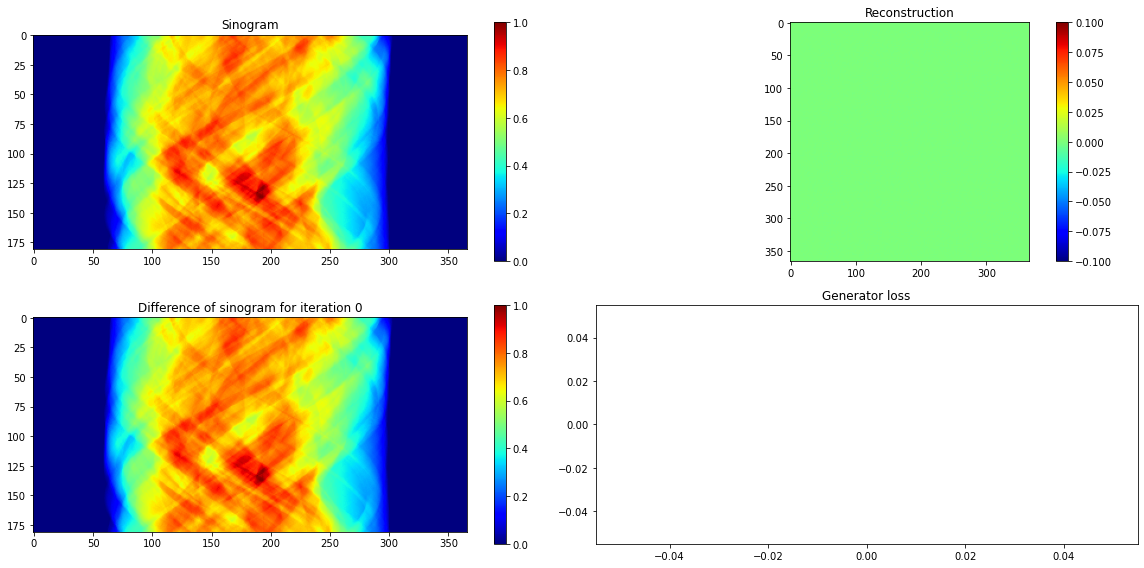

In [42]:
ganrec(prj, theta, 100)

In [29]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [30]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [34]:
display_image(100)

NameError: name 'display_image' is not defined